# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [6]:
test.isnull().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [7]:
test.fillna('', inplace = True)
train.fillna('', inplace = True)

In [8]:
train.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [9]:
train.groupby(by = 'target').count()['id']

target
0    3024
1    2305
Name: id, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

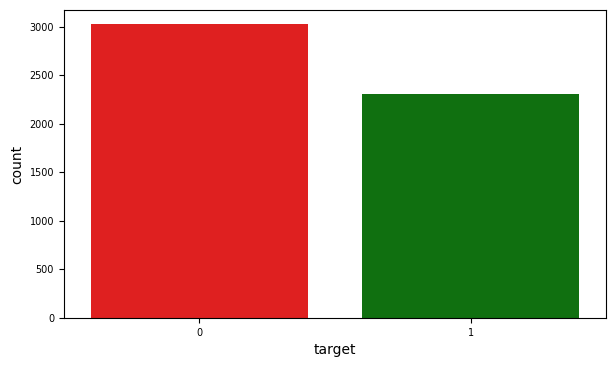

In [10]:
colour = {1 : 'g', 0 : 'r' }
sns.set_context({'xtick.labelsize': 7,
                 'ytick.labelsize': 7,
                 'figure.figsize': (7, 4),
                 'patch.linewidth': 0.0
                })
sns.countplot(x="target", data=train, palette = colour)


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [11]:
popular_keywords = list(train.groupby(by = 'keyword').count().sort_values(by = 'id', ascending = False).head(11).index[1:])
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'nuclear%20reactor',
 'derail',
 'emergency',
 'fatality',
 'fear']

<AxesSubplot:xlabel='keyword', ylabel='Count'>

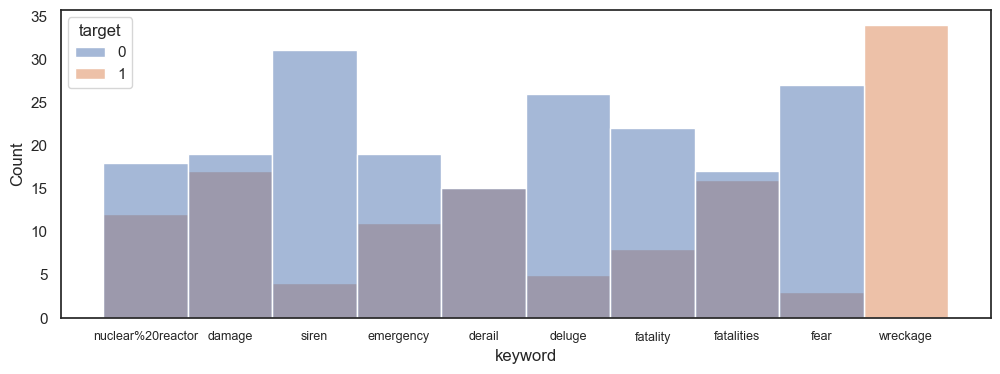

In [12]:
sns.set(style = 'white', rc={"figure.figsize":( 12 , 4 ), 'xtick.labelsize': 9})
sns.histplot(data = train[train['keyword'].isin(popular_keywords)], x="keyword", hue = 'target', fill = True, 
             multiple = 'layer')

**Выводы**: Большой перевес в 0 класс у слов 'siren', 'deluge', 'fear', 'fatality', во второй класс у 'wreckage', остальные же отличаются несильно

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [13]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [14]:
train_new = pd.DataFrame({'text': train['keyword'] + ' ' +train['location'] + ' ' + train['text'], 'target' : train['target']})

In [15]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_new['text'])
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

Размер: 5329x18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ синстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [17]:
def contains_digit(s: str) -> bool:
    for i in s:
        if i.isnumeric():
            return True
    else:
        return False

def contains_punctuation(s: str) -> bool:
    punc = ['.', '?', ',', '!', ';', '"', ':', '-', ')', '(']
    for i in s:
        if i in punctuation:
            return True
    return False

def is_hashtag(s: str) -> bool:
    if s[0] == '#':
        return True
    return False

def is_mention(s: str) -> bool:
    if s[0] == '@':
        return True
    return False

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', sum([contains_digit(i) for i in vocabulary.keys()])
          )
    print('With punctuation:', sum([contains_punctuation(i) for i in vocabulary.keys()])
          )
    print('Hashtags:        ', sum([is_hashtag(i) for i in vocabulary.keys()])
          )
    print('Mentions:        ', sum([is_mention(i) for i in vocabulary.keys()])
          )




In [18]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [19]:
investigate_vocabulary(vectorizer.vocabulary_
                       )

With digit:       3815
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [20]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [21]:
tknzr = TweetTokenizer()
vect = CountVectorizer(tokenizer = tknzr.tokenize)
vect.fit_transform(train_new['text'])

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [22]:
investigate_vocabulary(vect.vocabulary_
                       )

With digit:       3940
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** этот токенизатор справился намного лучше, в словаре появились упоминания и хэштеги, что может помочь в дальнейшем.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
import snowballstemmer
from nltk.corpus import stopwords

In [25]:
def contains_only_latin_letters(s: str) -> bool:
    l = range(65, 123)
    r = range(91, 97)
    for i in s:
        if ord(i) not in l or ord(i) in r:
            return False
    return True

def is_emoji(s: str) -> bool:
    for i in s:
        if i not in punctuation:
            return False
    if ('(' in s or ')' in s):
        return True
    return False

def is_hashtag(s: str) -> bool:
    return s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]: 
    tk = TweetTokenizer()
    x = tk.tokenize(s.lower())
    l = []
    for i in x:
        if i not in stopwords.words('english'):
            if contains_only_latin_letters(i):
                l.append(i)
            elif is_emoji(i) or is_hashtag(i):
                l.append(i)
    stemmer = snowballstemmer.stemmer('english')
    return stemmer.stemWords(l)
  

In [26]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [27]:
for i in range(1,11):
    print(custom_tokenizer(str(train_new.loc[[train_new.index[i]]]['text'])))

['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'tec', 'name', 'text', 'dtype', 'object']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'name', 'text', 'dtype', 'object']
['riot', 'still', 'riot', 'coupl', 'hour', 'le', 'name', 'text', 'dtype', 'object']
['wound', 'lake', 'highland', 'crack', 'path', 'name', 'text', 'dtype', 'object']
['airplan', 'somewher', 'expert', 'name', 'text', 'dtype', 'object']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'name', 'text', 'dtype', 'object']
['burn', 'except', 'idk', 'name', 'text', 'dtype', 'object']
['destroy', '(', 'ask', ')', 'destroy', 'hous', 'name', 'text', 'dtype', 'object']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'name', 'text', 'dtype', 'object']
['wreck', 'current', 'write', 'book', 'friggi', 'name', 'text', 'dtype', 'object']


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [28]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
bow = vectorizer.fit_transform(train_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [29]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score

In [30]:
from sklearn.linear_model import LogisticRegression
test_new = pd.DataFrame({'text': test['keyword'] + ' ' +test['location'] + ' ' + test['text'], 'target' : test['target']})
bow_test = vectorizer.transform(test_new['text'])


clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_new['target'])
pred = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [31]:
from sklearn.metrics import f1_score

print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7533584094572812


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

#scaler = MaxAbsScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#tfidf_test = scaler.transform(tfidf_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7422222222222221


1. **Ответ:** качество модели упало

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [33]:
tfidf_vec = TfidfVectorizer(max_df=0.9,tokenizer = custom_tokenizer )
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

#scaler = MaxAbsScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#tfidf_test = scaler.transform(tfidf_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7422222222222221


2. **Ответ:** Качество модели не изменилось

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [34]:
tfidf_vec = TfidfVectorizer(min_df=0.01, max_df = 0.99, tokenizer = custom_tokenizer)
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

#scaler = MaxAbsScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#tfidf_test = scaler.transform(tfidf_test)

clf = LogisticRegression(max_iter=400, random_state=42)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.6288361320208454


3. **Ответ:** Улучшений добиться не получилось

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [35]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=5000, tokenizer = custom_tokenizer)
hv = vectorizer.fit_transform(train_new['text'])
hv_test = vectorizer.transform(test_new['text'])


clf = LogisticRegression(max_iter=400, random_state=42)
clf.fit(hv, train_new['target'])
pred = clf.predict(hv_test)
print('F1 score:', f1_score(test_new['target'], pred))

C:\Users\user\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7190635451505016


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Лучший результат показал подход в задании 8, но f1 мера у всех подходов оказалось примерно около 0.75, только у `HashingVectorizer` отличалось хоть как-то значимо (если не брать в расчёт задание 9.3)

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

См. задание №8 или вот:

In [36]:
vec = CountVectorizer()
bow = vec.fit_transform(train_new['text'])  # bow — bag of words (мешок слов)
bow_test = vec.transform(test_new['text'])

#scaler = MaxAbsScaler()
#bow = scaler.fit_transform(bow)
#bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_new['target'])
pred = clf.predict(bow_test)
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7533729087965461


В нашей задаче масштабирование признаков (пробовал различные Scaler'ы) только ухудшает качество моделей. Как и наш токенизатор.